# Skills-ML Tour

Skills-ML is an open source software library for applying NLP and ML to labor market data. It allows the user to perform tasks like skill extraction and occupation classification to collections of documents such as job postings, profiles, and course descriptions.

## Competency

A competency is any expertise or talent that is useful for a job. Developed capacities (e.g. active listening), proficiency with tools or technology (e.g. lancets, Microsoft Word), innate abilities (e.g. originality), and academic knowledge (e.g. medicine) are all considered competencies.

In [1]:
from skills_ml.ontologies import Competency

dinosaur_riding = Competency(
    identifier='dino_riding',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

### Competency Relationships

Competencies are often related to each other. Defining parent-child relationships is a standard building block of existing competency frameworks like ONET and ESCO. A parent-child relationship generally implies that the child is a "type of" the parent.

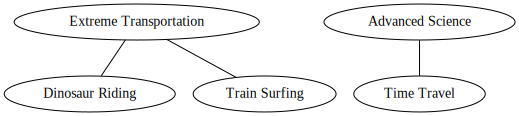

In [2]:
from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes

dinosaur_riding = Competency(
    identifier='12345',
    name='Dinosaur Riding',
    description='Using the back of a dinosaur for transportation'
)

train_surfing = Competency(
    identifier='12346',
    name='Train Surfing',
    description='Standing on the train while it goes'
)

time_travel = Competency(
    identifier='23456',
    name='Time Travel',
    description='Traveling Through Time'
)

advanced_science = Competency(
    identifier='2345',
    name='Advanced Science',
)

extreme_transportation = Competency(
    identifier='123',
    name='Extreme Transportation',
    description='Comically dangerous forms of transportation'
)
time_travel.add_parent(advanced_science)
dinosaur_riding.add_parent(extreme_transportation)
train_surfing.add_parent(extreme_transportation)
display_nodes([dinosaur_riding, train_surfing, extreme_transportation, time_travel, advanced_science])

## Occupation

An occupation is a job or profession that a person can hold. Similar to competencies, these are also often defined hierarchically.


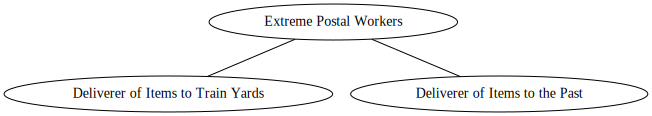

In [3]:
from skills_ml.ontologies import Occupation

extreme_postal_workers = Occupation(identifier='999', name='Extreme Postal Workers')
dino_postal_worker = Occupation(identifier='9998', name='Deliverer of Items to the Past')
train_yard_postal_worker = Occupation(identifier='9999', name='Deliverer of Items to Train Yards')
dino_postal_worker.add_parent(extreme_postal_workers)
train_yard_postal_worker.add_parent(extreme_postal_workers)

display_nodes([extreme_postal_workers, dino_postal_worker, train_yard_postal_worker])

# CompetencyOntology

A CompetencyOntology is a model of the labor market, or some subset thereof, consisting of a collection of competencies, a collection of occupations, and all of the relationships between them.

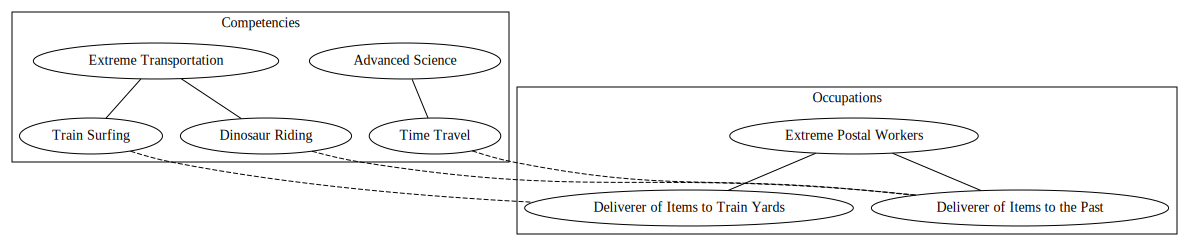

In [4]:
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

ontology = CompetencyOntology()
ontology.add_competency(dinosaur_riding)
ontology.add_competency(train_surfing)
ontology.add_competency(extreme_transportation)
ontology.add_competency(time_travel)
ontology.add_competency(advanced_science)

ontology.add_occupation(dino_postal_worker)
ontology.add_occupation(train_yard_postal_worker)
ontology.add_occupation(extreme_postal_workers)

ontology.add_edge(occupation=dino_postal_worker, competency=dinosaur_riding)
ontology.add_edge(occupation=dino_postal_worker, competency=time_travel)
ontology.add_edge(occupation=train_yard_postal_worker, competency=train_surfing)

display_ontology(ontology)